# NIRISS/SOSS Flux Calibration

This notebook will walk you through the additional steps necessary for flux calibration of NIRISS/SOSS observations.
This notebook assumes that you've already worked through the NIRISS/SOSS reduction notebook and have produced the relevant outputs (everything up until Stage 3).

In [ ]:
# First thing to do is set your CRDS variables so we can download the most up-to-date JWST 
# reference files. 

import os
os.environ['CRDS_PATH'] = './crds_cache'
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

Flux calibration converts the extracted stellar spectra into "real" units (e.g., erg/s/cm^2/µm) from the pipeline default "data numbers" (DN/s) or electrons (e/s). This invovles correcting the wavelength-dependent instrument throughput and applying the relevant unit conversions which were calibrated during commissioning using flux standard stars. 

We start this tutorial with the BadPixStep (or PCAReconstructStep) Stage 2 outputs from the NIRISS/SOSS reduction tutorial.

In [ ]:
# Specify the input directory containing the BadPixStep outputs.

indir = 'pipeline_outputs_directory/Stage2/'

# Lists of the BadPixStep outputs for each segment.

filenames = [indir + 'jw01366001001_04101_00001-seg001_nis_badpixstep.fits',
             indir + 'jw01366001001_04101_00001-seg002_nis_badpixstep.fits',
             indir + 'jw01366001001_04101_00001-seg003_nis_badpixstep.fits',
             indir + 'jw01366001001_04101_00001-seg004_nis_badpixstep.fits']

In [ ]:
# Now define the output directory path.

outdir_s3 = 'pipeline_outputs_directory/Stage3/'

Now we're ready to start the flux calibration. Unlike for NIRSpec, we generally do all the necessary steps to allow for flux calibration in the normal SOSS workflow. So now to perform the actual flux calibration is pretty straightforward!

## Flux Calibration Workflow

### 1D Spectral Extraction
We should have already done everything up util the spectral extraction in the reduction tutorial. This means that you should have all the necessary outputs to perform the flux calibration.  

In [ ]:
# We need the Stage 3 pipeline.

from exotedrf import stage3

The first thing we need are the trace centroids.

In [ ]:
import pandas as pd

# Open the centroids file. 

centroids = pd.read_csv(indir + 'jw01366001001_04101_00001_nis_centroids.csv', comment='#')

Unlike with NIRSpec, the extraction with used for the SOSS flux calibration is very specific. A 40-pixel full width is necessary since the flux standards were extracted using this same width. So to allow for a correct comparison, we have to do the same now. If you use a different extraction width, you could end up with wavelength-dependent biases.

In [ ]:
# Extract the spectra using the correct aperture size. 

step = stage3.Extract1DStep(filenames, extract_method='box', output_dir=outdir_s3)

results = step.run(extract_width=40, centroids=centroids, save_results=True, force_redo=True)

Now we need to do the actual flux calibration. This happens after the extraction and is a different process than for NIRSpec -- mainly because the standard PhotomStep isn't ideal for SOSS observations as there is not a 1-to-1 pixel to wavelength mapping due to the overlapping orders.  

There are a couple of extra files and values that we need to allow for the flux calibration.  
The first is the pupil wheel position at the time of the observations. We can pull this from the header.

In [ ]:
from astropy.io import fits

# Get the pupil wheel position.

pwcpos = fits.getheader(indir + 'jw01366001001_04101_00001-seg001_nis_badpixstep.fits')['PWCPOS']

Now we need two more reference files which are not necessarily widely available. The first is the old jwst spectrace file which contains the expected positions of the SOSS spectral trace and the wavelength mapping for each pixel in each order. This has recently been superceded with a pastasoss file and as such, is not longer available on the crds. Luckily, there's a version hosted on the exoTEDRF GitHub, Let's grab that now.

In [ ]:
from exotedrf.extra_functions import download_ref_file

# Download the spectrace file. 
# Note: for SUBSTRIP256 observations we need jwst_niriss_spectrace_0022.fits, and for SUBSTRIP96 
# jwst_niriss_spectrace_0023.fits. Make sure you grab the correct one!
# In this case the observations use SUBSTRIP256.

filename = 'jwst_niriss_spectrace_0022.fits'  # File to download.
url = 'https://raw.githubusercontent.com/radicamc/exoTEDRF/main/files/'  # Host url.
outdir = './'  # Local directory to which to save the file.
    
download_ref_file(filename, url, outdir)

Next we need the flux calibration reference file. Again, we're going to use a custom version created during commissioning by Kevin Volk which is hosted on the exoTEDRF GitHub. Using the standard crds photom file can result in biases (see e.g., Lim et al. 2023).

In [ ]:
# Download the photom file.

filename = 'jwst_niriss_photom_rev2.fits'

download_ref_file(filename, url, outdir)

We're now ready for the flux calibration!  

In [ ]:
# Collect the necessary files.

spectrum_file = 'pipeline_outputs_directory/Stage3/WASP-39_box_spectra_fullres.fits'
photom_path = 'jwst_niriss_photom_rev2.fits'
spectrace_path = 'jwst_niriss_spectrace_0022.fits'

In [ ]:
# Perform the flux calibration.
# Here we're calibrating both orders, but can do just order 1 or 2 by passing the appropriate value(s) to orders.

stage3.flux_calibrate_soss(spectrum_file, pwcpos, photom_path, spectrace_path, orders=[1, 2])

This step produces another spectrum file, but with the FluxCalibrated tag.  

## Inspect Outputs

Let's unpack the extracted spectra and inspect the results.

In [ ]:
# Open the flux calibrated spectrum file.

spectrum = fits.open(outdir_s3 + 'WASP-39_box_spectra_fullres_FluxCalibrated.fits')

# Get the wavelength axes.

wave1 = spectrum[1].data
wave2 = spectrum[5].data

# Restrict the order 2 wavelengths to the useable portion.
ii = np.where((wave2 < 0.85) & (wave2 >= 0.6))[0]
wave2 = wave2[ii]

In general, we want to work with the out-of-transit stellar spectra, so that there is no bias or imprint of the planet. 

In [ ]:
# Unpack the extracted spectra and median over the out-of-transit baseline (first 100 integrations).

spec1 = np.nanmedian(spectrum[3].data[:100], axis=0)
spec2 = np.nanmedian(spectrum[7].data[:100, ii], axis=0)

# We'll use the scatter along the time axis as the error.

spec_err1 = np.nanstd(spectrum[4].data[:100], axis=0)
spec_err2 = np.nanstd(spectrum[8].data[:100, ii], axis=0)

For a point of comparison, let's use a PHOENIX model.

In [ ]:
from exotedrf import utils

# Download a PHOENIX spectrum using the grid point closest to the parameters of WASP-39.

_ = utils.download_stellar_spectra(5500, 4.5, 0, './')

In [ ]:
# Open the PHOENIX spectra and wavelength files. 

mod_wave = fits.getdata('WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')*1e-4  # Convert to µm.
mod_spec = fits.getdata('lte05500-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')*1e-4 # Convert to µm.

The extracted stellar spectra are measured at Earth (or close enough), whereas the PHEONIX models effectively provide flux at the surface of the star. So we need one more conversion to allow for an apples-to-apples comparison.

In [ ]:
# Rescale the PHOENIX model spectrum by the inverse-square law for flux. 

Rs = 0.939 * 6.96e8  # Radius of WASP-39 in m.
d = 213.982 * 3.086e16  # Distance to WASP-39 in m.

# Apply the flux rescaling.

mod_spec *= (Rs/d)**2

In [ ]:
from scipy.ndimage import gaussian_filter

# And let's smooth the model spectrum for visualization purposes. 

mod_spec = gaussian_filter(mod_spec, 300)

Now let's plot up the model and extracted stellar spectra.

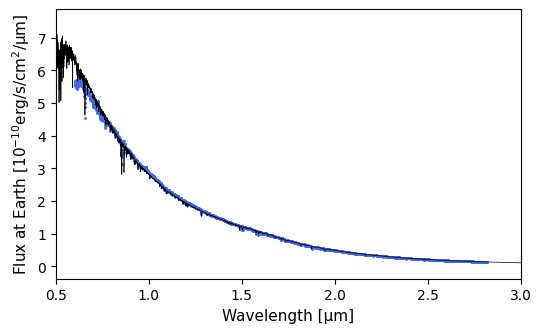

In [197]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3.5))

# Here we're trimming some edge effects from each order.
# We're also rescaling the flux by ~10% to get a better match to the model spectrum. This is not unexpected 
# and can be due to e.g., stellar brightness variations.

plt.errorbar(wave1[5:-17], spec1[5:-17]*1.12*1e10, yerr=spec_err1[5:-17]*1e10, c='royalblue', ms=1, fmt='o')
plt.errorbar(wave2, spec2*1.12*1e10, yerr=spec_err2*1e10, c='royalblue', ms=1, fmt='o')

# And plot up the model spectrum.

plt.plot(mod_wave, mod_spec*1e10, c='black', lw=0.5, zorder=5)

plt.xlim(0.5, 3.0)
plt.ylabel(r'Flux at Earth [$\rm 10^{-10} erg/s/cm^2/µm$]', fontsize=11)
plt.xlabel('Wavelength [µm]', fontsize=11)
plt.show()

The match is pretty good!

And voilà, you now have a flux-calibrated stellar spectrum.